In [1]:
import os
import pickle
import sys
from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import proplot as pplt
import scipy.fft
from tqdm.notebook import trange
from ipywidgets import interact
from ipywidgets import widgets

sys.path.append("/home/46h/repo/psdist/")
import psdist as ps
import psdist.visualization as psv

import lebedev_bogacz as LB
from read_bunch import read_bunch

In [2]:
pplt.rc["colorbar.width"] = "1.2em"
pplt.rc["cmap.discrete"] = False
pplt.rc["cmap.sequential"] = "viridis"
pplt.rc["figure.facecolor"] = "white"
pplt.rc["grid"] = False

In [3]:
save = False

In [4]:
timestamp = 231003143948
script_name = "paint_root"
datadir = f"../../data_output/sns_ring/{script_name}/{timestamp}/"    
os.listdir(datadir)

['paint_root.py',
 'log.txt',
 'lattice_params.pkl',
 'lattice_twiss.dat',
 'lattice_dispersion.dat',
 'lattice_params_4d.pkl',
 'lattice_twiss_4d.dat',
 'inj_traj_t0.dat',
 'fig_inj_traj_t0.png',
 'inj_traj_t1.dat',
 'fig_inj_traj_t1.png',
 'history.dat',
 'bunch_00001.dat',
 'fig_proj2d_xxp_inj_00001.png',
 'fig_proj2d_yyp_inj_00001.png',
 'fig_proj2d_xy_inj_00001.png',
 'fig_corner_4d_inj_00001.png',
 'fig_proj2d_xxp_inj_00051.png',
 'fig_proj2d_yyp_inj_00051.png',
 'fig_proj2d_xy_inj_00051.png',
 'fig_corner_4d_inj_00051.png',
 'bunch_00100.dat',
 'fig_proj2d_xxp_inj_00101.png',
 'fig_proj2d_yyp_inj_00101.png',
 'fig_proj2d_xy_inj_00101.png',
 'fig_corner_4d_inj_00101.png',
 'fig_proj2d_xxp_inj_00151.png',
 'fig_proj2d_yyp_inj_00151.png',
 'fig_proj2d_xy_inj_00151.png',
 'fig_corner_4d_inj_00151.png',
 'bunch_00200.dat',
 'fig_proj2d_xxp_inj_00201.png',
 'fig_proj2d_yyp_inj_00201.png',
 'fig_proj2d_xy_inj_00201.png',
 'fig_corner_4d_inj_00201.png',
 'fig_proj2d_xxp_inj_00251.png',


In [5]:
if save:
    outdir = f"../../figures/sns_ring/{script_name}/{timestamp}/"
    if not os.path.isdir(outdir):
        os.makedirs(outdir)

def save_figure(filename):
    if not save:
        return
    filename = os.path.join(outdir, filename)
    plt.savefig(filename)

## Linear lattice analysis 

### Transfer matrix

In [6]:
file = open(os.path.join(datadir, "lattice_params_4d.pkl"), "rb")
lattice_params_4d = pickle.load(file, encoding="latin1")
file.close()

pprint(lattice_params_4d)

{'M': array([[ 5.14920817e-01,  1.11482410e+01,  1.43310082e-02,
         3.90576372e-01,  0.00000000e+00, -1.08153045e-01,
         0.00000000e+00],
       [-7.21237690e-02,  3.69771363e-01, -7.88608929e-03,
         1.71917435e-01,  0.00000000e+00, -5.04788326e-03,
         0.00000000e+00],
       [-8.70195983e-02, -1.83949217e+00,  4.58743538e-01,
         1.09030532e+01,  0.00000000e+00,  4.44946724e-03,
         0.00000000e+00],
       [ 7.28985164e-03,  9.03906115e-02, -7.32165819e-02,
         4.27628561e-01,  0.00000000e+00,  2.94296116e-06,
         0.00000000e+00],
       [ 1.28507685e-02,  2.05599384e-02,  7.36776351e-04,
        -1.81707708e-02,  1.00000000e+00,  5.12820225e+01,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.0

### Position-dependent parameters

These might be wrong.... they were computed by analyzing the transfer matrix starting from each node, rather than propagating the Twiss parameters along the beamline.

In [7]:
filename = os.path.join(datadir, "lattice_twiss_4d.dat")
twiss_4d = pd.read_table(filename, sep=" ", index_col=0)
twiss_4d.head()

,s,beta_1x,beta_1y,beta_2x,beta_2y,alpha_1x,alpha_1y,alpha_2x,alpha_2y,u,nu1,nu2
0,0.000000,1.566787,6.672547,6.652847,1.149864,0.241296,0.014828,0.002076,-0.203434,0.900497,-3.141593,-0.000000
1,0.883004,1.491677,6.675362,6.678243,1.220815,0.228533,-0.018016,-0.030837,0.216318,0.887611,-3.141593,-3.141593
2,1.378195,1.454384,6.702325,6.713864,1.267727,0.223069,-0.036435,-0.041967,-0.223829,0.883489,-3.141593,-0.000000
3,1.873387,1.419711,6.747531,6.761344,1.319654,-0.217439,-0.054854,-0.053900,0.231502,0.879243,-0.000000,-3.141593
4,2.963570,1.362668,6.911341,6.953526,1.452101,-0.199702,-0.095405,-0.108504,-0.248841,0.860369,-0.000000,-0.000000


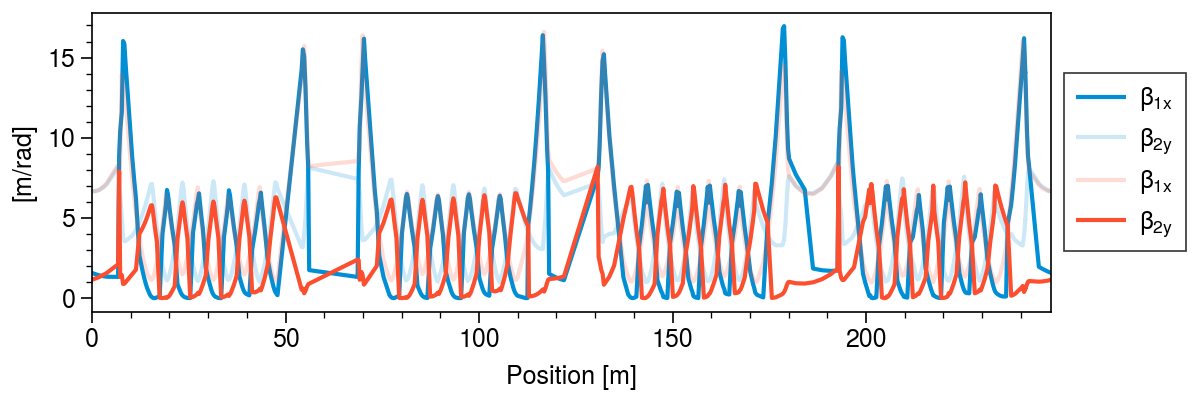

In [8]:
fig, ax = pplt.subplots(figsize=(6, 2))
_colors = pplt.Cycle("538").by_key()["color"]
ax.plot(twiss_4d["s"], twiss_4d["beta_1x"], label=r"$\beta_{1x}$", color=_colors[0])
ax.plot(twiss_4d["s"], twiss_4d["beta_1y"], label=r"$\beta_{2y}$", color=_colors[0], alpha=0.2)
ax.plot(twiss_4d["s"], twiss_4d["beta_2x"], label=r"$\beta_{1x}$", color=_colors[1], alpha=0.2)
ax.plot(twiss_4d["s"], twiss_4d["beta_2y"], label=r"$\beta_{2y}$", color=_colors[1])
ax.legend(loc="right", ncols=1)
ax.format(xlabel="Position [m]", ylabel="[m/rad]")
save_figure("twiss_4d")
plt.show()

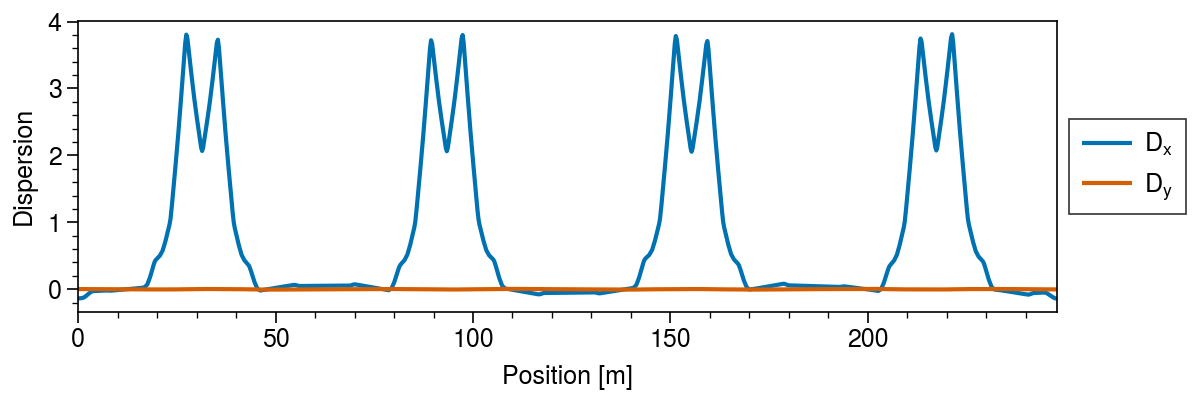

In [9]:
filename = os.path.join(datadir, "lattice_dispersion.dat")
dispersion = pd.read_table(filename, sep=" ", index_col=0)

fig, ax = pplt.subplots(figsize=(6, 2))
ax.plot(dispersion["s"], dispersion["disp_x"], label=r"$D_x$")
ax.plot(dispersion["s"], dispersion["disp_y"], label=r"$D_y$")
ax.legend(loc="right", ncols=1)
ax.format(xlabel="Position [m]", ylabel="Dispersion")
save_figure("dispersion")
plt.show()

## Scalar history 

In [10]:
history = pd.read_csv(os.path.join(datadir, "history.dat"))
history.columns

Index(['eps_x', 'y_rms', 'cov_1-1', 'energy', 'cov_1-3', 'cov_1-4', 'cov_3-3',
       'eps_y', 'n_parts', 'z_rms', 'cov_3-4', 'cov_0-5', 'cov_4-5', 'cov_0-4',
       'z_max', 'cov_1-5', 'cov_5-5', 'cov_1-2', 'cov_0-0', 'cov_3-5', 'y_min',
       'eps_2', 'cov_2-5', 'eps_1', 'x_rms', 'cov_4-4', 'x_min', 'z_min',
       'x_max', 'cov_2-4', 'y_max', 'beta', 'cov_2-3', 'cov_2-2', 'cov_0-1',
       'gamma', 'cov_0-3', 'cov_0-2', 'mean_4', 'mean_5', 'mean_0', 'mean_1',
       'mean_2', 'mean_'],
      dtype='object')

In [11]:
figsize = (4.0, 3.0)

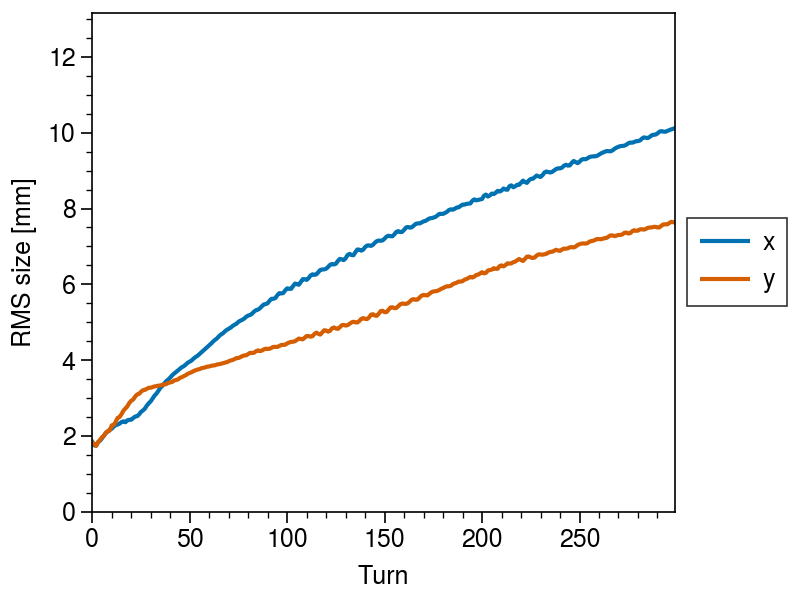

In [12]:
fig, ax = pplt.subplots(figsize=figsize)
ax.plot(1000.0 * history.loc[:, "x_rms"].values, label="x")
ax.plot(1000.0 * history.loc[:, "y_rms"].values, label="y")
ax.format(ymin=0.0, ymax=(1.25 * ax.get_ylim()[1]))
ax.format(xlabel="Turn", ylabel="RMS size [mm]")
ax.legend(loc="r", ncols=1)
save_figure("rms")
plt.show()

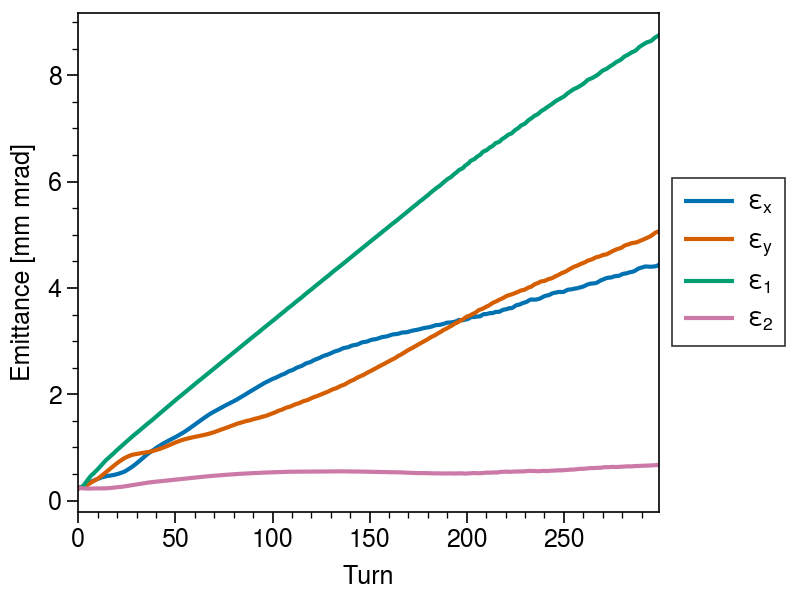

In [13]:
colors = pplt.Cycle("538").by_key()["color"]

fig, ax = pplt.subplots(figsize=figsize)
ax.plot(1.00e+06 * history.loc[:, "eps_x"].values, label=r"$\varepsilon_x$", color=None, ls="-")
ax.plot(1.00e+06 * history.loc[:, "eps_y"].values, label=r"$\varepsilon_y$", color=None, ls="-")
ax.plot(1.00e+06 * history.loc[:, "eps_1"].values, label=r"$\varepsilon_1$", color=None, ls="-")
ax.plot(1.00e+06 * history.loc[:, "eps_2"].values, label=r"$\varepsilon_2$", color=None, ls="-")
ax.format(xlabel="Turn", ylabel="Emittance [mm mrad]")
ax.legend(loc="r", ncols=1)
save_figure("emittance")
plt.show()

### Moments

In [14]:
# for i in range(4):
#     for j in range(i + 1):
#         key = f"cov_{j}-{i}"
#         fig, ax = pplt.subplots(figsize=figsize)
#         ax.plot(1.00e+06 * history.loc[:, key], color="black")
#         _dims = ["x", "x'", "y", "y'"]
#         ylabel = r"$\langle {} {} \rangle$".format(_dims[j], _dims[i])
#         ax.format(xlabel="Turn", ylabel=ylabel)
#         plt.show()

## Phase space distribution 

In [15]:
filenames = os.listdir(datadir)
filenames = [f for f in filenames if f.startswith("bunch")]
filenames = sorted(filenames)
filenames = [os.path.join(datadir, f) for f in filenames]
pprint(filenames)

['../../data_output/sns_ring/paint_root/231003143948/bunch_00001.dat',
 '../../data_output/sns_ring/paint_root/231003143948/bunch_00100.dat',
 '../../data_output/sns_ring/paint_root/231003143948/bunch_00200.dat',
 '../../data_output/sns_ring/paint_root/231003143948/bunch_00300.dat']


In [16]:
bunches = []
for filename in filenames:
    bunch = read_bunch(filename)
    bunches.append(bunch)

In [17]:
widget = psv.cloud.proj2d_interactive_slice(
    data=[
        bunch.values[:, :6]
        for bunch in bunches
    ],
    dims=list(bunch.columns[:6]),
    share_limits=2,
    options=dict(ellipse=True, profiles=True),
    prof_kws=dict(color="black"),
    rms_ellipse_kws=dict(color="black", level=2.0),
    autolim_kws=dict(pad=0.25),
    cmap=pplt.Colormap("blues"),
    mask=True,
    colorbar=True,
)
display(widget)

interactive(children=(BoundedIntText(value=0, description='frame', max=3), Dropdown(description='dim 1', optio…

In [18]:
dims = ["x", "xp", "y", "yp", "z", "dE"]
limits = psv.combine_limits([
    psv.cloud.auto_limits(bunch.values[:, :6], pad=0.2)
    for bunch in bunches
])

In [19]:
@interact(
    index=widgets.BoundedIntText(min=0, max=(len(bunches) - 1), value=0),
    dim1=widgets.Dropdown(options=dims, value=dims[0]),
    dim2=widgets.Dropdown(options=dims, value=dims[1]),
    bins=widgets.IntSlider(min=4, max=128, value=45),
)
def update(
    index,
    dim1,
    dim2,
    bins,
    log=False,
):
    if dim1 == dim2:
        return
    axis = (dims.index(dim1), dims.index(dim2))
    X = bunches[index].values[:, axis]
    
    grid = psv.JointGrid()
    grid.plot_cloud(
        X,
        bins=bins,
        limits=[limits[k] for k in axis], 
        norm=("log" if log else None),
        mask=True,
        cmap=pplt.Colormap("blues"),
    )
    grid.ax.format(xlabel=dims[axis[0]], ylabel=dims[axis[1]])
    if log:
        grid.ax_marg_x.format(yscale="log", yformatter="log")
        grid.ax_marg_y.format(xscale="log", xformatter="log")

interactive(children=(BoundedIntText(value=0, description='index', max=3), Dropdown(description='dim1', option…